In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import sys
import pprint
import random
import time
import tqdm
import logging
import argparse
import numpy as np

import torch
import torch.nn as nn
import torch.multiprocessing as mp
import torch.distributed as dist

import losses
import models
import datasets
import lib.utils as utils
from lib.utils import AverageMeter
from optimizer.optimizer import Optimizer
from evaluation.evaler import Evaler
from scorer.scorer import Scorer
from lib.config import cfg, cfg_from_file


from torchvision import transforms
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.data.transforms import _pil_interp
import cv2
from PIL import Image



In [4]:
class Tester(object):
    def __init__(self, args):
        super(Tester, self).__init__()
        self.args = args
        self.device = torch.device("cuda")
        self.vocab = utils.load_vocab(args.vocab)
        
        self.transform = transforms.Compose([
            transforms.Resize((384, 384), interpolation=_pil_interp('bicubic')),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)]
        )

        self.setup_network()

    def setup_network(self):
        model = models.create(cfg.MODEL.TYPE)
        print(model)
        self.model = torch.nn.DataParallel(model).cuda()
        if self.args.resume > 0:
            self.model.load_state_dict(
                torch.load(self.snapshot_path("caption_model", self.args.resume),
                    map_location=lambda storage, loc: storage)
            )
            
    def make_kwargs(self, indices, ids, gv_feat, att_feats, att_mask):
        kwargs = {}
        kwargs[cfg.PARAM.INDICES] = indices
        kwargs[cfg.PARAM.GLOBAL_FEAT] = gv_feat
        kwargs[cfg.PARAM.ATT_FEATS] = att_feats
        kwargs[cfg.PARAM.ATT_FEATS_MASK] = att_mask
        kwargs['BEAM_SIZE'] = 5
        kwargs['GREEDY_DECODE'] = True
        return kwargs
    
    def read_img(self, image):
        img = cv2.imread(image)
        img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        att_feats = self.transform(img)[None].cuda()
        return att_feats
    
    def inference_img(self, image):
        with torch.no_grad():
            indices = 0
            ids = image
            gv_feat = None
            att_feats = self.read_img(image)
            att_mask = torch.ones(1, 12*12).cuda()
            
            kwargs = self.make_kwargs(indices, ids, gv_feat, att_feats, att_mask)
            if kwargs['BEAM_SIZE'] > 1:
                seq, _ = self.model.module.decode_beam(**kwargs)
            else:
                seq, _ = self.model.module.decode(**kwargs)
                
            sents = utils.decode_sequence(self.vocab, seq.data)
            # print(ids, ''.join(sents[0].split(' ')))
            return ' '.join(sents[0].split(' '))
        
    def eval(self, epoch, images):
        self.model.eval()
        
        caps = []
        for image in images:
            cap = self.inference_img(image)
            caps.append(cap)
        return caps
            

    def snapshot_path(self, name, epoch):
        snapshot_folder = os.path.join(cfg.ROOT_DIR, 'snapshot')
        return os.path.join(snapshot_folder, name + "_" + str(epoch) + ".pth")

def parse_args():
    """
    Parse input arguments
    """
    parser = argparse.ArgumentParser(description='Image Captioning')
    parser.add_argument('--folder', dest='folder', default=None, type=str)
    parser.add_argument("--resume", type=int, default=-1)
    parser.add_argument("--vocab", type=str, 
                        default='./mscoco/txt/coco_vocabulary.txt')
    # parser.add_argument("--images", type=str, nargs='+', default='')

    if len(sys.argv) == 1:
        parser.print_help()
        sys.exit(1)

    args = parser.parse_args(args=['--folder', './experiments_PureT/PureT_SCST/', '--resume', '27'])
    return args

In [5]:
args = parse_args()
    
print('Called with args:')
print(args)

if args.folder is not None:
    cfg_from_file(os.path.join(args.folder, 'config.yml'))
cfg.ROOT_DIR = args.folder

tester = Tester(args)

Called with args:
Namespace(folder='./experiments_PureT/PureT_SCST/', resume=27, vocab='./mscoco/txt/coco_vocabulary.txt')
load pretrained weights!
PureT(
  (backbone): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        dim=192, input_resolution=(96, 96), depth=2
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=192, input_resolution=(96, 96), num_heads=6, window_size=12, shift_size=0, mlp_ratio=4.0
            (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              dim=192, window_size=(12, 12), num_heads=6
              (qkv): Linear(in_features=192, out_features=576, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Line

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

def vis_img_cap(img_files, caps):
    assert len(img_files) == len(caps), 'error'
    for i in range(len(img_files)):
        img_file = img_files[i]
        cap = caps[i]
        img = cv2.imread(img_file)
        img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.imshow(img)
        plt.show()
        print(img_file, cap)

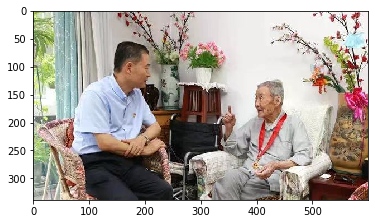

./VisImgs/19.jpg two men sitting in chairs in a room with flowers


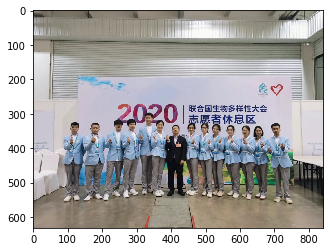

./VisImgs/11.jpg a group of people standing on a stage


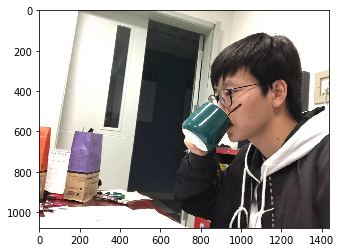

./VisImgs/14.jpg a man drinking out of a cup


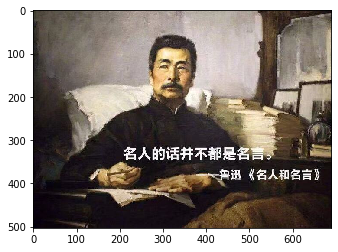

./VisImgs/7.jpg a painting of a man sitting in front of a table


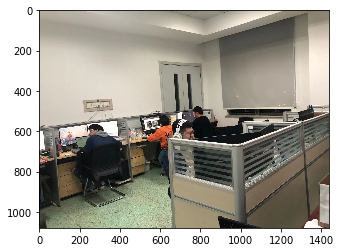

./VisImgs/1.jpg an office with people sitting at computers in an office


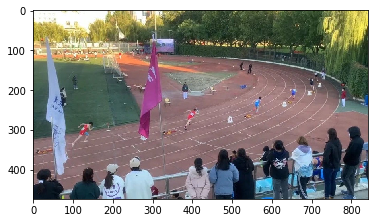

./VisImgs/8.jpg a crowd of people standing on a race track


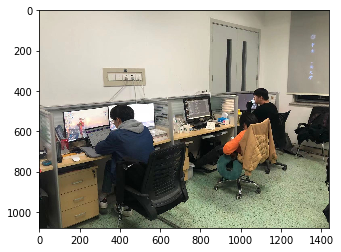

./VisImgs/6.jpg two people sitting at an office desk with computers


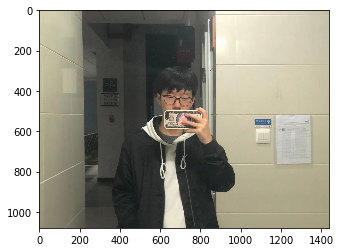

./VisImgs/16.jpg a man taking a picture of himself in a bathroom mirror


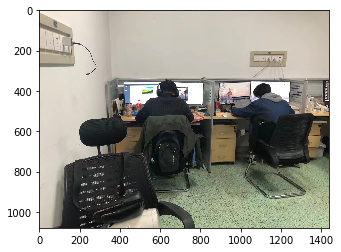

./VisImgs/5.jpg a group of people sitting at an office desk


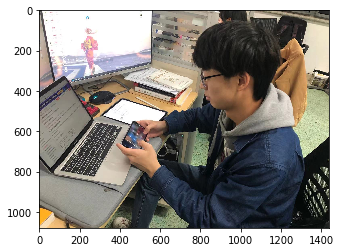

./VisImgs/13.jpg a man sitting at a desk with a laptop computer


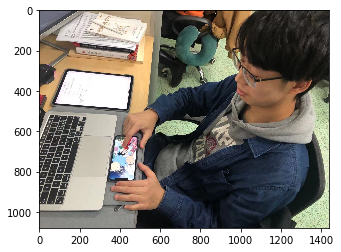

./VisImgs/10.jpg a young man sitting at a desk with a laptop computer


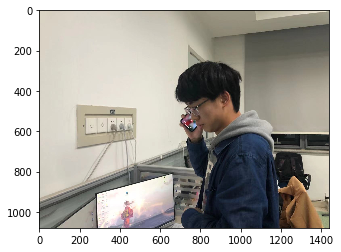

./VisImgs/12.jpg a man sitting at a desk with a computer monitor


In [7]:
img_files = [os.path.join('./VisImgs', _) for _ in os.listdir('./VisImgs/') if '.jpg' in _]
caps = tester.eval(args.resume, img_files)
vis_img_cap(img_files, caps)